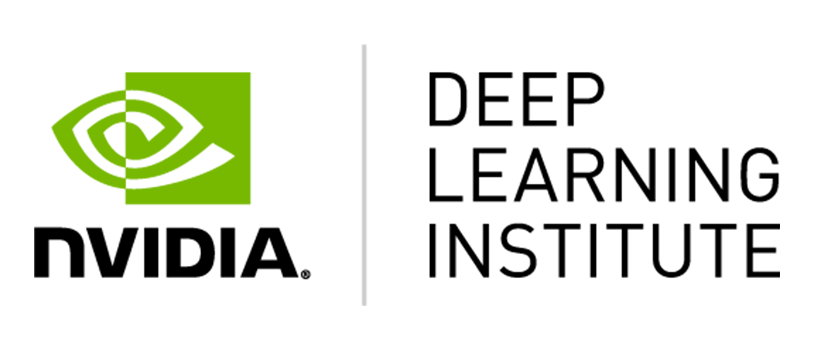

# 3. Convolutional Neural Networks

In the previous section, we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

## 3.1 Objectives

* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance

In [18]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import torchvision.io as tv_io

from sklearn.metrics import confusion_matrix
import seaborn as sns  # 히트맵을 그릴 때 사용
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 3.2 Loading and Preparing the Data

### 3.2.1 Preparing Images

Let's begin by loading our DataFrames like we did in the previous lab:

In [19]:
train_df = pd.read_csv("asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("asl_data/sign_mnist_valid.csv")

In [20]:
train_df.shape, valid_df.shape

((27455, 785), (7172, 785))

This ASL data is already flattened.

In [21]:
sample_df = train_df.head().copy()  # Grab the top 5 rows
sample_y = sample_df.pop('label')
sample_x = sample_df.values

sample_x, sample_y

(array([[107, 118, 127, ..., 204, 203, 202],
        [155, 157, 156, ..., 103, 135, 149],
        [187, 188, 188, ..., 195, 194, 195],
        [211, 211, 212, ..., 222, 229, 163],
        [164, 167, 170, ..., 163, 164, 179]], dtype=int64),
 0     3
 1     6
 2     2
 3     2
 4    12
 Name: label, dtype: int64)

In [22]:
sample_x.shape, sample_y.shape

((5, 784), (5,))

In [23]:
sample_df


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(5, 784)` to `(5, 1, 28, 28)`. With [NumPy](https://numpy.org/doc/stable/index.html) arrays, we can pass a `-1` for any dimension we wish to remain the same.

In [24]:
# sample_x.shape : (5, 784)

IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

sample_x = sample_x.reshape(-1, IMG_CHS, IMG_HEIGHT, IMG_WIDTH)  # x = x.unsqueeze(1)  # (5, 28, 28) → (5, 1, 28, 28)
sample_x.shape

(5, 1, 28, 28)

### 3.2.2 Create a Dataset

Let's add the steps above into our `MyDataset` class.

In [25]:
class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()  # Some operations below are in-place
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, 1, 28, 28)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

# x_df = base_df.copy()
# Pandas에서 DataFrame을 슬라이싱하거나 인덱싱하면 원본 DataFrame의 뷰가 반환됩니다.
# 뷰를 수정하면 원본 DataFrame도 수정됩니다. .copy() 메서드를 사용하여 복사본을 만들면
# 원본 DataFrame에 영향을 주지 않고 복사본을 수정할 수 있음

### 3.2.3 Create a DataLoader

Next, let's create the DataLoader from the Dataset

One of these function calls is missing the `shuffle=True` argument. Can you remember which one it is and add it back in?

In [26]:
BATCH_SIZE = 32

train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

train_N, valid_N

(27455, 7172)

In [27]:
iter_train_N = len(train_loader) # 전체 train data의 수를 batch_size로 나눈 값 : 27455 / 32
iter_valid_N = len(valid_loader)
iter_train_N, iter_valid_N

(858, 225)

In [28]:
train_data.__getitem__(0), train_data.__len__(), train_data.__getitem__(0)[0].shape

((tensor([[[0.4196, 0.4627, 0.4980, 0.5255, 0.5451, 0.5608, 0.5725, 0.5882,
            0.6000, 0.6118, 0.6196, 0.6275, 0.6392, 0.6471, 0.6235, 0.6510,
            0.6588, 0.6667, 0.6667, 0.6706, 0.6706, 0.6706, 0.6745, 0.6706,
            0.6706, 0.6667, 0.6667, 0.6627],
           [0.4353, 0.4745, 0.5059, 0.5294, 0.5529, 0.5647, 0.5804, 0.5922,
            0.6039, 0.6157, 0.6275, 0.6392, 0.6431, 0.6667, 0.4667, 0.5961,
            0.6706, 0.6706, 0.6667, 0.6706, 0.6745, 0.6745, 0.6745, 0.6745,
            0.6745, 0.6706, 0.6706, 0.6667],
           [0.4431, 0.4824, 0.5137, 0.5373, 0.5569, 0.5686, 0.5882, 0.5961,
            0.6078, 0.6196, 0.6314, 0.6392, 0.6431, 0.6745, 0.4118, 0.5569,
            0.6667, 0.6706, 0.6706, 0.6706, 0.6745, 0.6745, 0.6784, 0.6784,
            0.6745, 0.6706, 0.6706, 0.6706],
           [0.4549, 0.4902, 0.5216, 0.5451, 0.5608, 0.5725, 0.5922, 0.6000,
            0.6118, 0.6235, 0.6353, 0.6392, 0.6549, 0.6549, 0.3725, 0.5647,
            0.6706, 0.6745, 0

In [29]:
train_data.__len__(), valid_data.__len__()

(27455, 7172)

Let's grab a batch from the DataLoader to make sure it works.

In [30]:
batch = next(iter(train_loader))
batch, type(batch), len(batch[0])

([tensor([[[[0.7686, 0.7686, 0.7725,  ..., 0.6824, 0.6784, 0.6706],
            [0.7765, 0.7725, 0.7804,  ..., 0.6902, 0.6863, 0.6745],
            [0.7804, 0.7804, 0.7843,  ..., 0.7020, 0.6902, 0.6824],
            ...,
            [0.4392, 0.4510, 0.4549,  ..., 0.1137, 0.1647, 0.0863],
            [0.4392, 0.4392, 0.4314,  ..., 0.0980, 0.1451, 0.0588],
            [0.4471, 0.4392, 0.4314,  ..., 0.0941, 0.1333, 0.0549]]],
  
  
          [[[0.7804, 0.7922, 0.8039,  ..., 0.7725, 0.7647, 0.7569],
            [0.7922, 0.8039, 0.8118,  ..., 0.7804, 0.7725, 0.7725],
            [0.8000, 0.8078, 0.8157,  ..., 0.7882, 0.7843, 0.7765],
            ...,
            [0.5882, 0.4549, 0.4510,  ..., 0.9333, 0.9255, 0.9216],
            [0.4824, 0.4392, 0.4353,  ..., 0.9294, 0.9216, 0.9176],
            [0.4745, 0.4314, 0.4196,  ..., 0.9255, 0.9255, 0.9176]]],
  
  
          [[[0.6314, 0.6471, 0.6471,  ..., 0.6667, 0.6588, 0.6588],
            [0.6392, 0.6471, 0.6510,  ..., 0.6706, 0.6627, 0.6627]

It looks different, but let's check the `shape`s to be sure.

In [31]:
batch[0].shape

torch.Size([32, 1, 28, 28])

In [32]:
batch[1].shape

torch.Size([32])

In [33]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


## 3.3 Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

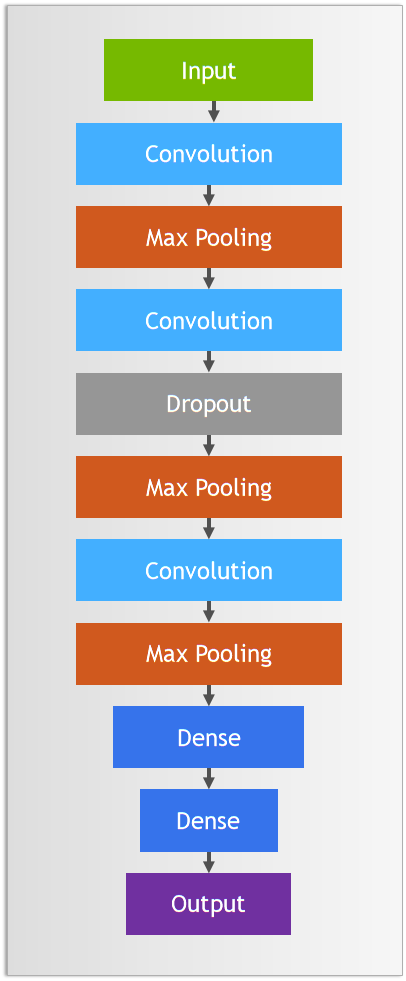

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [Stack Overflow](https://stackoverflow.com/)).

In [34]:
n_classes = 24
kernel_size = 3
flattened_img_size = 75 * 3 * 3

# 3개의 입력 채널, 64개의 출력 채널, 3x3 커널, stride 1, padding 1을 사용하는 Conv2d 레이어 생성
# example :
# conv_layer = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
# in_channels (int): 입력 이미지의 채널 수. 예를 들어, 흑백 이미지는 1개의 채널, RGB 이미지는 3개의 채널을 가짐.
# out_channels (int): 컨볼루션 연산 후 출력되는 채널 수로 필터의 개수와 같습니다.

'''
model = nn.Sequential(
    # First convolution
    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28 -> ((28-3+2*1)/1)+1 = 28
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14  -> ((28-2)/2)+1 = 14

    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14  -> ((14-3+2*1)/1)+1 = 14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7  -> ((14-2)/2)+1 = 7

    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7  -> ((7-3+2*1)/1)+1 = 7
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3   -> ((7-2)/2)+1 = 3.5 = 3

    # Flatten to Dense
    nn.Flatten(),
    
    # LazyLinear로 변경
    # nn.LazyLinear(512),
    nn.Linear(flattened_img_size, 512),

    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, n_classes)
)
model
'''

'\nmodel = nn.Sequential(\n    # First convolution\n    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28 -> ((28-3+2*1)/1)+1 = 28\n    nn.BatchNorm2d(25),\n    nn.ReLU(),\n    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14  -> ((28-2)/2)+1 = 14\n\n    # Second convolution\n    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14  -> ((14-3+2*1)/1)+1 = 14\n    nn.BatchNorm2d(50),\n    nn.ReLU(),\n    nn.Dropout(.2),\n    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7  -> ((14-2)/2)+1 = 7\n\n    # Third convolution\n    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7  -> ((7-3+2*1)/1)+1 = 7\n    nn.BatchNorm2d(75),\n    nn.ReLU(),\n    nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3   -> ((7-2)/2)+1 = 3.5 = 3\n\n    # Flatten to Dense\n    nn.Flatten(),\n    \n    # LazyLinear로 변경\n    # nn.LazyLinear(512),\n    nn.Linear(flattened_img_size, 512),\n\n    nn.Dropout(.3),\n    nn.ReLU(),\n    nn.Linear(512, n_classes)\n)\nmodel\n'

In [35]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

In [36]:
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

### 3.3.1 [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

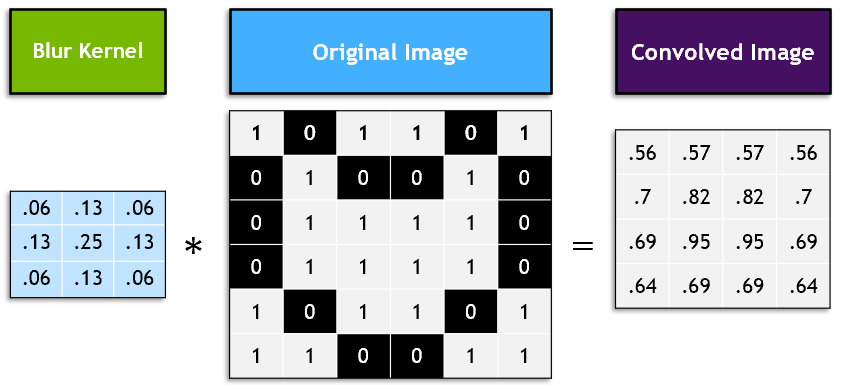

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1)
```
25 refers to the number of filters that will be learned. Even though `kernel_size = 3`, PyTorch will assume we want 3 x 3 filters. Stride refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

### 3.3.2 [BatchNormalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

There is a debate on best where to put the batch normalization layer. [This Stack Overflow post](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) compiles many perspectives.

### 3.3.3 [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

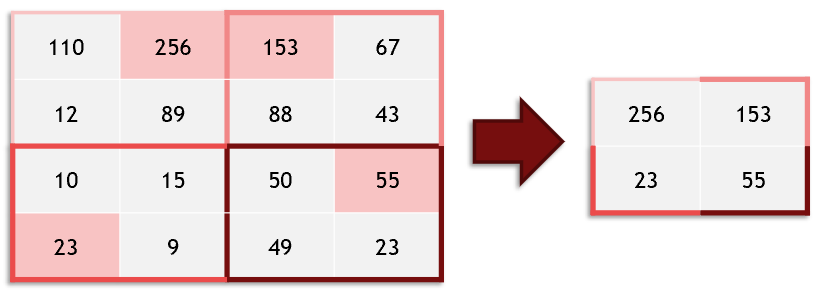
Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### 3.3.4 [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

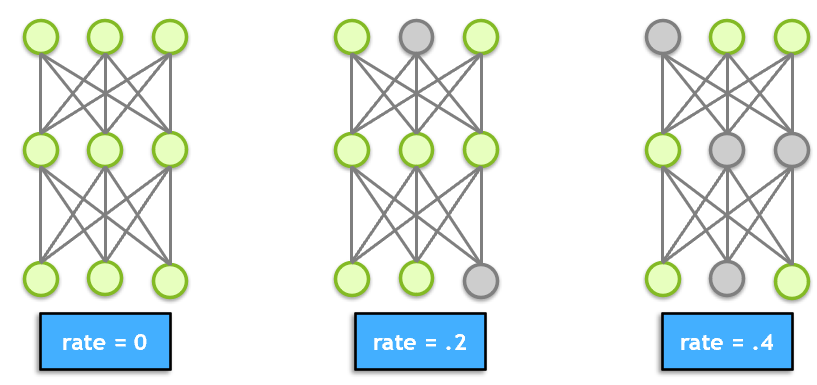
Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### 3.3.5 [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### 3.3.6 [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

We have seen dense linear layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## 3.4 Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

In [37]:
# compile : 모델 성능 최적화
# model = torch.compile(model.to(device))
model = base_model.to(device)
model

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

Since the problem we are trying to solve is still the same (classifying ASL images), we will continue to use the same `loss_function` and `accuracy` metric.

In [38]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [1]:
# def get_batch_accuracy(output, y, N):
#     pred = output.argmax(dim=1, keepdim=True)
#     correct = pred.eq(y.view_as(pred)).sum().item()
#     return correct / N

## Data Augmentation

In [40]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

### 3.5 Training the Model

Despite the very different model architecture, the training looks exactly the same.

In [41]:
train_loss, train_accuracy = [],[]

def train():
    running_loss = 0
    running_accuracy = 0

    model.train()
    for x, y in train_loader: # x, y는 batch 단위(32개씩)로 처리
        output = model(random_transforms(x))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y) # batch_loss는 32개 batch의 평균오차
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item() * x.size(0)  # x.size(0) : BATCH SIZE
        
        pred = output.argmax(dim=1, keepdim=True)
        running_accuracy += pred.eq(y.view_as(pred)).sum().item()
    
    
    loss = running_loss / train_N   
    accuracy = running_accuracy / train_N
    ######
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    ######

    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [42]:
valid_loss, valid_accuracy = [],[]
y_trues, y_preds = [],[]

def validate():
    running_loss = 0
    running_accuracy = 0
    
    # y_trues = []
    # y_preds = []

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            running_loss += loss_function(output, y).item() * x.size(0)
            
            pred = output.argmax(dim=1, keepdim=True)
            running_accuracy += pred.eq(y.view_as(pred)).sum().item()
            
            # 정답과 예측을 리스트에 저장
            y_trues.extend(y.cpu().numpy().tolist())
            y_preds.extend(pred.cpu().numpy().tolist())
            
    
    loss = running_loss / valid_N   
    accuracy = running_accuracy / valid_N
    ######
    valid_loss.append(loss)
    valid_accuracy.append(accuracy)
    ######
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [43]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()
    print()

Epoch: 0
Train - Loss: 0.7858 Accuracy: 0.7430
Valid - Loss: 0.2293 Accuracy: 0.9285

Epoch: 1
Train - Loss: 0.1290 Accuracy: 0.9592
Valid - Loss: 0.1271 Accuracy: 0.9550

Epoch: 2
Train - Loss: 0.0691 Accuracy: 0.9780
Valid - Loss: 0.0933 Accuracy: 0.9693

Epoch: 3
Train - Loss: 0.0500 Accuracy: 0.9836
Valid - Loss: 0.1073 Accuracy: 0.9593

Epoch: 4
Train - Loss: 0.0366 Accuracy: 0.9885
Valid - Loss: 0.0438 Accuracy: 0.9848

Epoch: 5
Train - Loss: 0.0349 Accuracy: 0.9884
Valid - Loss: 0.0871 Accuracy: 0.9732

Epoch: 6
Train - Loss: 0.0304 Accuracy: 0.9897
Valid - Loss: 0.0834 Accuracy: 0.9728

Epoch: 7
Train - Loss: 0.0297 Accuracy: 0.9900
Valid - Loss: 0.1702 Accuracy: 0.9518

Epoch: 8
Train - Loss: 0.0267 Accuracy: 0.9915
Valid - Loss: 0.0638 Accuracy: 0.9819

Epoch: 9
Train - Loss: 0.0189 Accuracy: 0.9940
Valid - Loss: 0.1579 Accuracy: 0.9639



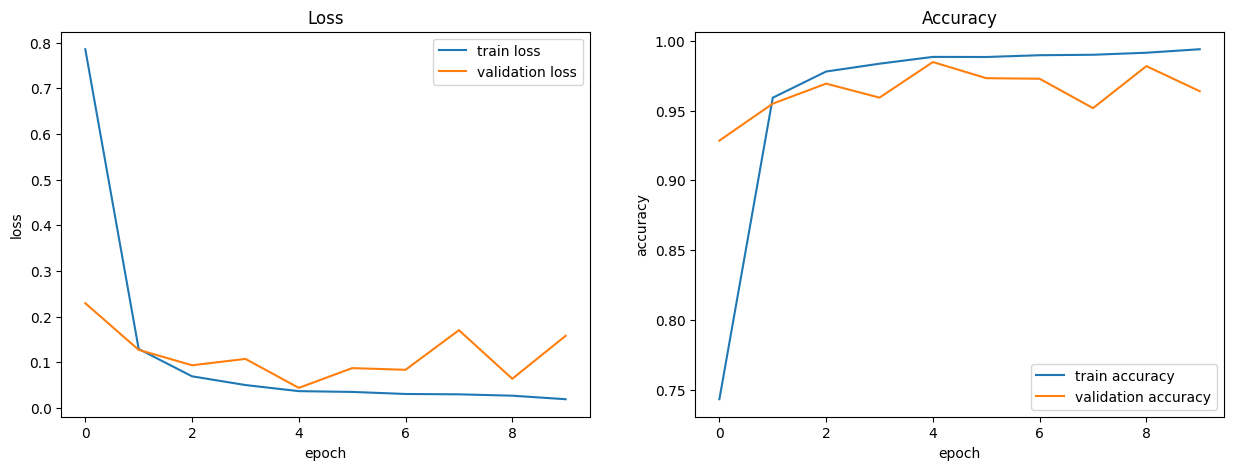

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_loss, label = 'train loss')
plt.plot(valid_loss, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(train_accuracy, label = 'train accuracy')
plt.plot(valid_accuracy, label = 'validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

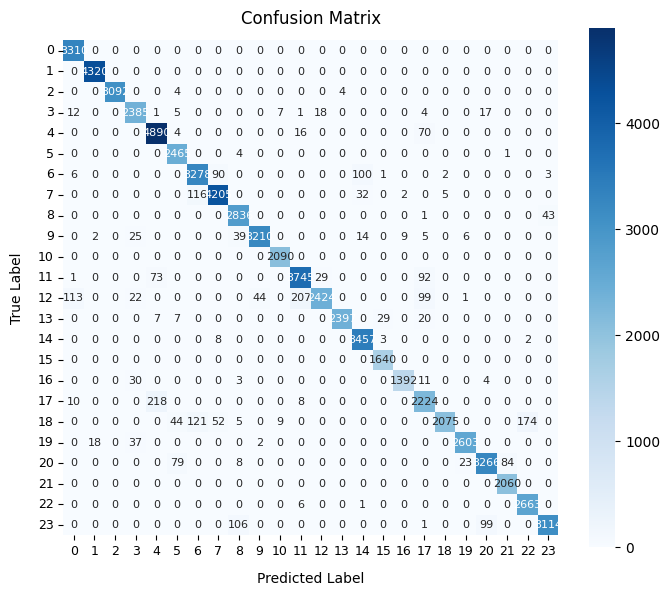

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_trues, y_preds)

# 전체 크기를 작게 고정
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0,
    linecolor=None,
    annot_kws={'fontsize': 8},  # 숫자 폰트 크기 축소
    square=True,
    ax=ax
)

ax.set_title('Confusion Matrix', pad=12, fontsize=12)
ax.set_xlabel('Predicted Label', labelpad=10, fontsize=10)
ax.set_ylabel('True Label', labelpad=10, fontsize=10)

ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=0, fontsize=9)
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, fontsize=9)

# tight_layout으로 여백 최적화
plt.tight_layout(pad=1.0)

plt.show()

In [111]:
from sklearn.metrics import classification_report

print(classification_report(y_trues, y_preds, digits=4))


              precision    recall  f1-score   support

           0     0.9342    1.0000    0.9660      3310
           1     0.9926    1.0000    0.9963      4320
           2     0.9968    0.9981    0.9974      3100
           3     0.9962    0.9669    0.9814      2450
           4     0.9794    0.9936    0.9864      4980
           5     0.9848    1.0000    0.9924      2470
           6     0.9435    0.9118    0.9274      3480
           7     0.9686    0.9690    0.9688      4360
           8     0.9430    0.9830    0.9626      2880
           9     0.9202    0.9927    0.9551      3310
          10     0.9543    1.0000    0.9766      2090
          11     0.9676    0.9013    0.9332      3940
          12     0.8894    0.8983    0.8938      2910
          13     0.9976    0.9980    0.9978      2460
          14     0.9264    0.9937    0.9588      3470
          15     0.9874    1.0000    0.9936      1640
          16     0.9565    0.9313    0.9437      1440
          17     0.9750    

In [ ]:
torch.save(model, 'asl_model_no_state.pth')

In [46]:
loaded_model = torch.load('asl_model_no_state.pth')
loaded_model

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

## Prediction

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

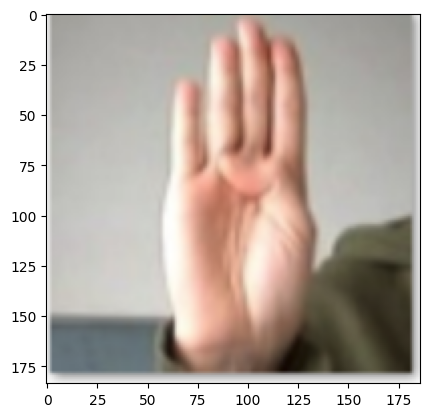

In [48]:
show_image('asl_images/b.png')

In [49]:
# Scaling the Images
image = tv_io.read_image('asl_images/b.png', tv_io.ImageReadMode.GRAY)
image, image.shape

(tensor([[[247, 223, 178,  ..., 223, 231, 238],
          [245, 221, 178,  ..., 213, 223, 232],
          [244, 220, 177,  ..., 204, 217, 228],
          ...,
          [247, 243, 238,  ..., 223, 231, 238],
          [249, 246, 243,  ..., 232, 238, 243],
          [250, 248, 246,  ..., 240, 243, 246]]], dtype=torch.uint8),
 torch.Size([1, 184, 186]))

In [50]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

# PIL 이미지를 바로 텐서로 바꾸고 싶다면 → ToTensor() 사용
# 이미 텐서인 이미지를 float32로 바꾸고 싶다면 → ToDtype() 사용

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

In [51]:
processed_image = preprocess_trans(image)
processed_image, processed_image.shape

(tensor([[[0.6960, 0.6279, 0.6348, 0.6493, 0.6584, 0.6599, 0.6638, 0.6630,
           0.6652, 0.6677, 0.6711, 0.6696, 0.6661, 0.6677, 0.7103, 0.6559,
           0.6369, 0.6507, 0.6464, 0.6379, 0.6293, 0.6216, 0.6139, 0.6074,
           0.5984, 0.5895, 0.5836, 0.6977],
          [0.7013, 0.6388, 0.6480, 0.6578, 0.6647, 0.6687, 0.6709, 0.6734,
           0.6746, 0.6794, 0.6814, 0.6784, 0.6902, 0.6801, 0.7648, 0.6606,
           0.5610, 0.6348, 0.6418, 0.6509, 0.6417, 0.6308, 0.6252, 0.6197,
           0.6095, 0.6007, 0.5923, 0.6773],
          [0.7061, 0.6479, 0.6588, 0.6668, 0.6743, 0.6811, 0.6845, 0.6848,
           0.6872, 0.6898, 0.6913, 0.6909, 0.7671, 0.6833, 0.6945, 0.6803,
           0.4720, 0.6061, 0.5686, 0.6548, 0.6566, 0.6471, 0.6380, 0.6273,
           0.6198, 0.6124, 0.6078, 0.6837],
          [0.7165, 0.6603, 0.6699, 0.6770, 0.6821, 0.6880, 0.6959, 0.7001,
           0.7027, 0.7014, 0.7009, 0.7041, 0.8257, 0.6885, 0.6387, 0.7202,
           0.4938, 0.6614, 0.5266, 0.6351, 

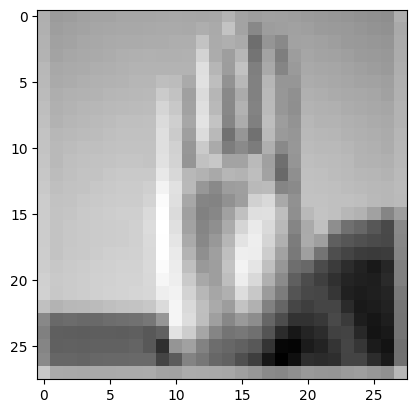

In [52]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

In [53]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

In [54]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cuda', index=0)

In [55]:
output = loaded_model(batched_image_gpu)
output

tensor([[-15.4772,   6.2517,  -6.9374, -14.0814,  -2.0442,  -4.9245,  -4.3687,
         -13.4870,  -3.7862,  -5.8354,  -0.1401,  -9.2118,  -6.6449, -20.9952,
          -7.6223, -12.4126, -13.7911, -20.1261, -11.0892,  -0.3296,  -9.6669,
           0.3157,  -7.2777, -13.2216]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [56]:
prediction = output.argmax(dim=1).item()
prediction

1

### 3.5.1 Discussion of Results

It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do. Let's talk about it in the next lecture.

## 3.6 Summary

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.

### 3.6.2 Next

In the last several sections you have focused on the creation and training of models. In order to further improve performance, you will now turn your attention to *data augmentation*, a collection of techniques that will allow your models to train on more and better data than what you might have originally at your disposal.

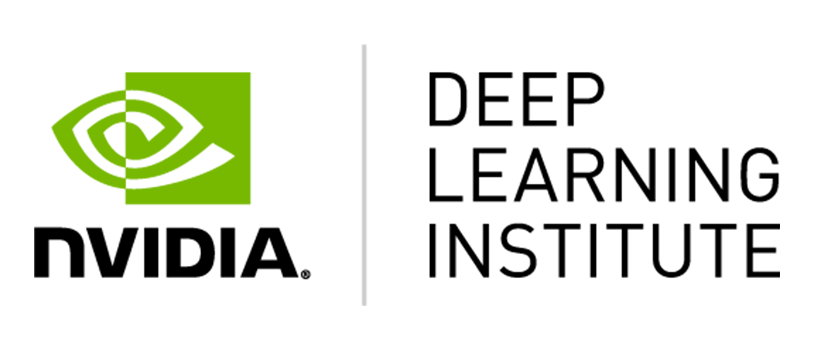